In [24]:
%pip install torch torchvision --user


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
# Постройте графики зависимости сходимости (значение функции потерь от количества итераций работы алгоритма)
# от выбора оптимизационного метода
# количество эпох = 50
# Сравните, сделайте выводы
# https://pytorch.org/docs/stable/optim.html

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

learning_rate = 0.001
epochs = 50

loss_fn = nn.CrossEntropyLoss()

In [26]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [27]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    sum_loss = 0
    model.train() 
    for batch, (X, y) in enumerate(dataloader):
        # Вычисляем предсказание и потерю
        pred = model(X)
        loss = loss_fn(pred, y)
        sum_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss_value = loss.item()
            current = batch * dataloader.batch_size + len(X)
            print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")

    return sum_loss / len(dataloader)

In [28]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [29]:
def run_training(epochs, train_dataloader, model, loss_fn, optimizer):
    test_loss = []
    train_loss = []
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        sum_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        train_loss.append(sum_loss)

        acc, avg_loss = test_loop(test_dataloader, model, loss_fn)
        test_loss.append(avg_loss)
    print("Done!")

    return train_loss, test_loss

Epoch 1
-------------------------------
loss: 2.299935  [   64/60000]
loss: 2.291820  [ 6464/60000]
loss: 2.267336  [12864/60000]
loss: 2.272593  [19264/60000]
loss: 2.249136  [25664/60000]
loss: 2.221354  [32064/60000]
loss: 2.233738  [38464/60000]
loss: 2.198305  [44864/60000]
loss: 2.204434  [51264/60000]
loss: 2.170727  [57664/60000]
Test Error: 
 Accuracy: 55.3%, Avg loss: 2.161877 

Epoch 2
-------------------------------
loss: 2.174280  [   64/60000]
loss: 2.162742  [ 6464/60000]
loss: 2.104706  [12864/60000]
loss: 2.130449  [19264/60000]
loss: 2.069859  [25664/60000]
loss: 2.014692  [32064/60000]
loss: 2.047170  [38464/60000]
loss: 1.967746  [44864/60000]
loss: 1.987355  [51264/60000]
loss: 1.907138  [57664/60000]
Test Error: 
 Accuracy: 59.3%, Avg loss: 1.901669 

Epoch 3
-------------------------------
loss: 1.933970  [   64/60000]
loss: 1.902787  [ 6464/60000]
loss: 1.786221  [12864/60000]
loss: 1.839931  [19264/60000]
loss: 1.714111  [25664/60000]
loss: 1.661706  [32064/600

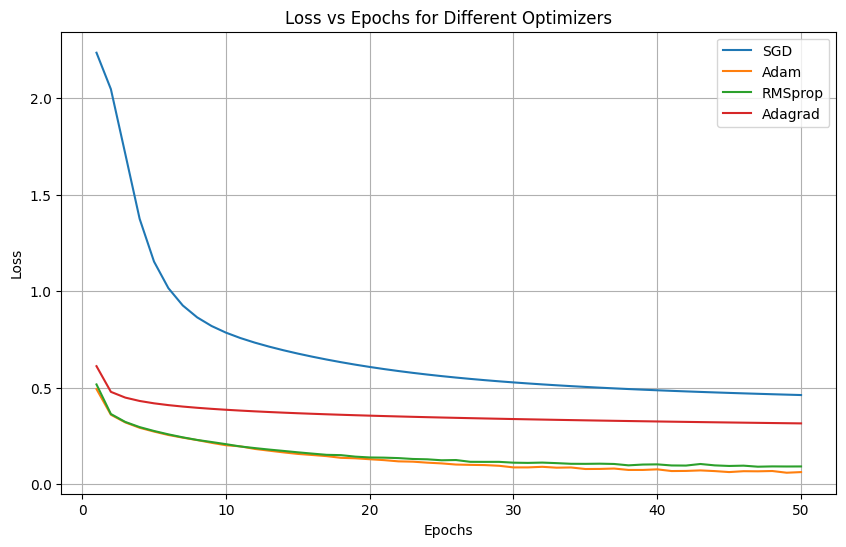

In [30]:
optimizers = {
    "SGD": torch.optim.SGD,
    "Adam": torch.optim.Adam,
    "RMSprop": torch.optim.RMSprop,
    "Adagrad": torch.optim.Adagrad
}

results = {}

for name, optimizer_class in optimizers.items():
    model = NeuralNetwork() 
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    
    train_loss, test_loss = run_training(epochs, train_dataloader, model, loss_fn, optimizer)
    results[name] = train_loss

plt.figure(figsize=(10, 6))
for name, losses in results.items():
    plt.plot(range(1, epochs + 1), losses, label=name)

plt.title('Loss vs Epochs for Different Optimizers')
plt.xlabel('Epochs')e
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

SGD:
Epoch 1: Средняя потеря составила около 2.16, а точность - 55.3%.
Epoch 50: Средняя потеря снизилась до 0.49, точность возросла до 82.6%%.
Заключение: SGD демонстрирует медленное начальное улучшение, достигая более низких значений потерь и увеличивая точность в последующих эпохах. Он требует больше эпох для достижения конкурентоспособных результатов.
Adam:
Epoch 1: Средняя потеря составила всего 0.42, а точность - 84.5%.
Epoch 2: Потеря снизилась до 0.08, а точность увеличилась до 88.4%.
Заключение: Adam показывает значительно более высокую эффективность по сравнению с SGD. Он достигает низких значений функции потерь и высокой точности уже на первой эпохе, что делает его предпочтительным выбором для быстрой сходимости.
RMSprop:
Epoch 1: Средняя потеря составила 0.44, с точностью 83.4%.
Epoch 2: Потеря снизилась до 0.11, а точность возросла до 88.3%.
Заключение: RMSprop обеспечивает стабильные и высокие показатели, схожие с Adam, с небольшим отставанием в начале. Его эффективность также делает его хорошим выбором для многих задач обучения.
Adagrad:
Epoch 1: Средняя потеря составила 0.52, а точность - 81.4%.
Epoch 2: Потеря снизилась до 0.37, точность возросла до 87.0%.
Заключение: Adagrad показывает приемлемые результаты, хотя они ниже, чем у Adam и RMSprop. Он может потребовать больше эпох для достижения сопоставимых значений потерь и точности.